In [1]:
from typing import TypedDict

from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task


class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str  

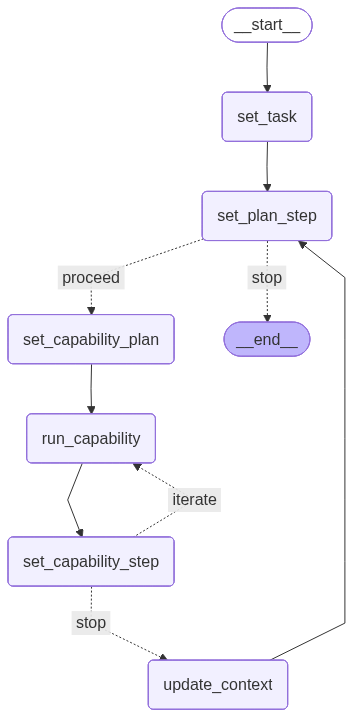

In [2]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor, AgentCapabilityCodeWritterExecutor
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


workflow = StateGraph(state_schema=ExecutionState)

def init_state(ask: str, resources: list[ContentResource] = list()) -> ExecutionState:
    # TODO: should I be using LLM to convert attachments/resources to acceptable format?
    # TODO: implement proper handling of attachments and resources 
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources,
    )

def set_task(state: ExecutionState) -> ExecutionState: 
    question_task = state["ask"]
    resources = state["resources"]
    task_plan_response = create_plan(question_task, resources)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    state["task"] = task

    return state

def set_plan_step(state: ExecutionState) -> ExecutionState: 
    """  
    Determine which state is being executed. 
    """
    if state["step"] is None: 
        state["step"] = 0 
    else:
        state["step"] += 1
         
    return state

def check_plan_completion(state: ExecutionState) -> str:
    # FIXME: delete me, see what to do with the showrt_anser var, now only for debugging?
    print("\nSHORT ANSWER:\n", construct_short_answer(state["task"].objective, state["context"]), "\n")
    
    # TODO: might incorporate early stopping if answer is found
    # if not short_answer | len(short_answer.answer) == 0 | short_answer.answer.lower() != "not found":
        
    plan_length = len(state["task"].plan)
    if state["step"] < plan_length:
        return "proceed"
    else:
        return "stop"

def set_capability_plan(state: ExecutionState) -> ExecutionState: 
    state["capability_plan"] = determine_capabilities(
        state["task"].plan[state["step"]], 
        task=state["task"], 
        resources=state["resources"],
        context=state["context"]
    )
    state["capability_plan_step"] = 0

    return state

def set_capability_step(state: ExecutionState) -> ExecutionState:
    if state["capability_plan_step"] is None:
        state["capability_plan_step"] = 0 
    else:
        state["capability_plan_step"] += 1 

    return state

def check_capability_step(state:ExecutionState) -> ExecutionState: 
    capability_plan_length = len(state["capability_plan"].subplan)
    if state["capability_plan_step"] < capability_plan_length:
        # run the next capability step
        return "iterate"        
    else: 
        # signal that we need to move over to the next state
        return "stop" 

def run_capability(state: ExecutionState) -> ExecutionState: 
    capability_agent = state["capability_plan"].subplan[state["capability_plan_step"]]
    output = None
    match capability_agent:
        case AgentCapabilityDeepWebSearch():
            output = capability_agent.run()
        case AgentCapabilityUnstructuredDataProcessor():
            output = capability_agent.run(state["resources"])
        case AgentCapabilityCodeWritterExecutor():
            output = capability_agent.run(state["resources"])
        case _:
            print("DEBUG | run_capability | Call to unidentified agent: ", capability_agent)
    answers = output.answers
    resources = output.resources

    if answers:
        state["answers"].extend(answers)
    if resources:
        state["resources"].extend(resources)

    return state

def update_context(state: ExecutionState) -> ExecutionState:
    asked = state["task"].plan[state["step"]]
    found = state['answers']
    context_delta = "\n" + str(
        {
            "asked": asked,
            "found": found,
        }
    ) 
    state["context"] += context_delta

    # # TODO: IMPORTANT need to save them somewhere else? 
    # state["resources"] = list()
    return state

FILE_NAME_SAVED_STATE = "state.pkl"
def save_state(state: ExecutionState):
    import pickle
    
    with open(FILE_NAME_SAVED_STATE, "wb") as f:
        pickle.dump(state, f)

def load_state(path: str = FILE_NAME_SAVED_STATE) -> ExecutionState:
    import pickle

    with open(path, "rb") as f:
        return pickle.load(f)

# Why: determine what we want to do and what we are given as input (e.g., some files)
workflow.add_node("set_task", set_task)
# Move over to producing an overarching plan: the steps of that plan you will follow one by one 
# Each step is a certain stage in getting to an asnwer. 
# E.g., plan = [Step1: searching internet for subquestion1; step2: search internet for an answer given answer to subquestion1 was YYY]
workflow.add_node("set_plan_step", set_plan_step)
# Answer to each step is determined by create a capabulity plan, i.e., which specialised agent(s) we would like to involve to get an answer. 
# a capability plan is dependent on the context (i.e., all the previous finds that we collected from previous steps)
workflow.add_node("set_capability_plan", set_capability_plan)
# Execute the capability plan one step at a time.
# For example, 1)capability_plan_step1: search web ; 2)capability_plan_step2: analyse whatever you found in previously  
workflow.add_node("run_capability", run_capability)
# Move over to the next capability_plan_step
workflow.add_node("set_capability_step", set_capability_step)
# When the capability plan is finished - summarise the results into the context 
# Context = list of all the answers to capability_plan execution=plan_step 's  
workflow.add_node("update_context", update_context)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "set_plan_step")
workflow.add_conditional_edges(
    "set_plan_step",
    check_plan_completion,
    {
        "proceed": "set_capability_plan",
        "stop": END,
    }
)
workflow.add_edge("set_capability_plan", "run_capability")
workflow.add_edge("run_capability", "set_capability_step")
workflow.add_conditional_edges(
    "set_capability_step", 
    check_capability_step,
    {
        "iterate":"run_capability",
        "stop": "update_context",
    }
)
workflow.add_edge("update_context", "set_plan_step")

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
# Test part nodes & logging
import logging

import mlflow

from generalist.models.core import MLFlowLLMWrapper
from generalist.utils import pprint
from generalist.tools import planning, web_search, text_processing, code

# STARTING TO LOG EVERYTHING (MANUALLY ADDED)
logging.getLogger().setLevel(logging.INFO)

mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
# MONKEY PATCH the llm call
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)
code.llm = MLFlowLLMWrapper(code.llm)

# FIXME: delete the if-statement, if wanting to test at this stage
if False: 
    question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."
    initial_state = init_state(question)

    state = set_task(initial_state)
    pprint(state["task"].__str__())

In [4]:
raise InterruptedError

InterruptedError: 

In [ ]:
# Test 1
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

2025-10-19 20:46:20,358 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/show "HTTP/1.1 200 OK"
2025-10-19 20:46:32,767 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/737920836275328806/runs/645486ce8971423dbf1935c4bff8c641
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:46:38,567 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "not found",
    "clarification": "The provided list does not contain any information related to the actor who portrayed Ray in the Polish-language version of Everybody Loves Raymond or their role in the film Magda M."
}
::construct_short_answer:
 ShortAnswer(answer='not found', clarification='The provided list does not contain any information related to the actor who portrayed Ray in the Polish-language version of Everybody Loves Raymond or their role in the film Magda M.')


2025-10-19 20:46:52,297 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/04a843481dfa4353af0186f85c155026
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:46:54,954 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/737920836275328806/runs/ec4e685be08d446c865234e9df2a8395
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806

Generated queries: ['actor who played ray in polish everybody loves raymond', 'polish actor ray everybody loves raymond']
!!!!!!!!!!!! search_url !!!!!!!!!! https://search.brave.com/search?q=actor+who+played+ray+in+polish+everybody+loves+raymond
!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.Dx4kXJAl.woff2" crossorigin="anonymous" rel=

2025-10-19 20:46:57,081 - httpx - INFO - HTTP Request: GET https://en.wikipedia.org/wiki/Wszyscy_kochaj%C4%85_Romana "HTTP/1.1 200 OK"


!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.Dx4kXJAl.woff2" crossorigin="anonymous" rel="preload" as="font" type="font/woff2" /> \n\t\t<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/app.BRznyb8s.css" rel="stylesheet"><!--[--><meta name="color-scheme" content=""/> <meta http-equiv="x-ua-compatible" content="IE=edge,chrome=1"/> <!--[!--><!--]--> <!--[--><meta name="robots" content="noindex,nofollow"/><!--]--> <meta name="description" content="Search the Web. Privately. Truly useful results, AI-powered answers, &amp; more. Al

2025-10-19 20:46:57,309 - httpx - INFO - HTTP Request: GET https://www.imdb.com/list/ls505203777/ "HTTP/1.1 403 Forbidden"
2025-10-19 20:47:08,293 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/6a023b3e7574455ca42fe0ee2619aa00
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  The name of the actor from the search results is Bartłomiej Kasprzykowski. He stars as the titular Roman in the Polish television sitcom "Wszyscy kochają Romana".


2025-10-19 20:47:13,803 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "Bartłomiej Kasprzykowski",
    "clarification": "The name is directly stated in the given list as the actor from the search results."
}


2025-10-19 20:47:20,914 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "not found",
    "clarification": "The provided list does not contain any information about the role played by Bartłomiej Kasprzykowski in a film named 'Magda M'. It only states that he portrayed Ray in the Polish adaptation of 'Everybody Loves Raymond'."
}
::construct_short_answer:
 ShortAnswer(answer='not found', clarification="The provided list does not contain any information about the role played by Bartłomiej Kasprzykowski in a film named 'Magda M'. It only states that he portrayed Ray in the Polish adaptation of 'Everybody Loves Raymond'.")


2025-10-19 20:47:44,957 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/62d83440062b46dc8626e3ec3cdc7ed5
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:47:48,016 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/737920836275328806/runs/d05a79dae84a45ae92ac5c95f6345518
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806

Generated queries: ['Bartłomiej Kasprzykowski Magda M film role', 'Magda M Bartłomiej Kasprzykowski actor']
!!!!!!!!!!!! search_url !!!!!!!!!! https://search.brave.com/search?q=Bartłomiej+Kasprzykowski+Magda+M+film+role
!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.Dx4kXJAl.woff2" crossorigin="anonymous" rel="preload" as="font" type="

2025-10-19 20:47:50,277 - httpx - INFO - HTTP Request: GET https://www.imdb.com/title/tt0471052/ "HTTP/1.1 403 Forbidden"
2025-10-19 20:47:50,454 - httpx - INFO - HTTP Request: GET https://www.filmweb.pl/serial/Magda+M.-2005-236958/cast/actors "HTTP/1.1 200 OK"
2025-10-19 20:47:51,071 - httpx - INFO - HTTP Request: GET https://en.wikipedia.org/wiki/Bart%C5%82omiej_Kasprzykowski "HTTP/1.1 200 OK"
2025-10-19 20:47:51,197 - httpx - INFO - HTTP Request: GET https://www.famousfix.com/topic/magda-m/cast "HTTP/1.1 403 Forbidden"
2025-10-19 20:48:21,642 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/46e2f43426594c3c8659da01c9050f9f
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  In the movie 'Magda M.', Bartłomiej Kasprzykowski played the role of Wojciech Płaska.


2025-10-19 20:48:28,518 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "Wojciech Płaska",
    "clarification": "This answer is based on the provided list where it states Bartłomiej Kasprzykowski played the role of Wojciech Płaska in 'Magda M.'"
}


2025-10-19 20:48:36,072 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "Wojciech Płaska",
    "clarification": "Based on the provided list, Bartłomiej Kasprzykowski played Wojciech Płaska in 'Magda M.'"
}
::construct_short_answer:
 ShortAnswer(answer='Wojciech Płaska', clarification="Based on the provided list, Bartłomiej Kasprzykowski played Wojciech Płaska in 'Magda M.'")


Trace(trace_id=c814c84d39e641adab39eb165b7a11e2)

In [ ]:
# Task 2 
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

2025-10-19 21:08:27,037 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/show "HTTP/1.1 200 OK"
2025-10-19 21:08:41,416 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/737920836275328806/runs/ded49d1ee80d40979632f1cef1be2a43
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 21:08:46,592 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


SHORT ANSWER:
 ShortAnswer(answer='not found', clarification="The provided list does not contain any relevant information about New York Yankees' at bats or walks during the 1977 regular season.")


2025-10-19 21:09:00,490 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/64a39a96a8fa434e8e173fa1f95d3738
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 21:09:03,146 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/737920836275328806/runs/23c48231887d432da36f5094a44dca47
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806

Generated queries: ['reliable baseball stats database 1977 MLB', 'detailed player stats 1977 MLB season']


2025-10-19 21:09:05,297 - httpx - INFO - HTTP Request: GET https://www.baseball-reference.com/ "HTTP/1.1 200 OK"



Found 3 unique web resources.


2025-10-19 21:09:06,354 - httpx - INFO - HTTP Request: GET https://www.mlb.com/stats/pitching/1977 "HTTP/1.1 200 OK"
2025-10-19 21:09:07,469 - httpx - INFO - HTTP Request: GET https://www.mlb.com/stats/batting-average/1977 "HTTP/1.1 200 OK"
2025-10-19 21:09:10,321 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/737920836275328806/runs/9ddc7b30ec0b4efd941adbe03322a05b
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806

Generated queries: ['Baseball statistics archive download', 'Best baseball stats database download']

Found 0 unique web resources.


2025-10-19 21:09:17,455 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


SHORT ANSWER:
 ShortAnswer(answer='not found', clarification='The provided list does not contain any information related to baseball statistics or player stats from the 1977 MLB season, making it impossible to determine the number of at bats for the New York Yankee with the most walks during that specific year.')


2025-10-19 21:11:54,640 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/8faf06b950064fa79625e89c2f82f213
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 21:12:24,013 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/f88fe5fed6864777a512ad334f610740
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  NOT FOUND


2025-10-19 21:12:59,961 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/1f607692f94746c1aef0b628004de251
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  NOT FOUND

The provided context does not contain specific player stats for the New York Yankees in 1977 that would allow us to determine which player had the highest number of walks during that year. The information listed includes links and descriptions rather than detailed statistical data.


2025-10-19 21:13:53,272 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/623458b43bd449218751469ea9439ed5
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  NOT FOUND

The provided context does not contain specific player stats for walks in the New York Yankees roster for 1977. The context includes hitting and pitching leaders but does not specify walk statistics or list players specifically for the New York Yankees team with their walk counts.


2025-10-19 21:14:02,185 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/b01c98a4785f4cbca7cd6cec9ffcdce0
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  NOT FOUND

The context provided does not contain specific walk statistics (bases on balls) for each player in a format that allows us to determine which New York Yankees player had the highest number of walks in 1977. The data given includes batting averages and other statistics but lacks the precise information needed to complete the task accurately.


2025-10-19 21:14:31,644 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/f6725be867ac4fbdaf050e88d0ceec7d
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  NOT FOUND


2025-10-19 21:15:02,626 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/af0b03abde7d4a39b3cd6fae32aaf4c5
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  NOT FOUND


2025-10-19 21:15:58,317 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/ec3b8b62b2244712b8717d3c062f23f8
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  The player with the most walks for the Yankees in the 1977 season, based on the data given, is Mickey Rivers. He had 18 walks and his at bats (AB) total was 565.

Therefore, the total at bats for the Yankee player who had the most walks during the 1977 season is **565**.


2025-10-19 21:16:07,818 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/737920836275328806/runs/c72d6bb871b24ae89ab3003906a051fa
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806
:::::: chunk_response ::::::  NOT FOUND

The context provided does not contain specific walk (BB) data for each player in a way that allows us to identify which Yankee player had the most walks during the 1977 season. The information given is incomplete for determining the total at bats for the player with the highest number of walks specifically for the New York Yankees team.


2025-10-19 21:16:13,844 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-19 21:16:20,096 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


SHORT ANSWER:
 ShortAnswer(answer='565', clarification='The total at bats for Mickey Rivers, who had the most walks during the 1977 season according to the given data.')


Trace(trace_id=b35172a6ab214f95b6f9d334efa36728)

In [ ]:
# Task 3
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "The attached Excel file contains the sales of menu items for a local fast-food chain. " \
"What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places."

sources = [
    ContentResource(
        provided_by="user", 
        content="", 
        link="/Users/maksim.rostov/pdev/freestyling/agents/hf-course/unit4_general_agent/generalist/notebooks/7bd855d8-463d-4ed5-93ca-5fe35145f733.xls",
        metadata={},
    )
]
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

2025-10-19 20:53:37,683 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/737920836275328806/runs/3c1c13c2097d47e59acb29cee87c98a6
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:53:44,714 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "not found",
    "clarification": "The input does not contain any relevant information about sales figures or a list of food and drink items."
}

::construct_short_answer:
 ShortAnswer(answer='not found', clarification='The input does not contain any relevant information about sales figures or a list of food and drink items.')


2025-10-19 20:53:58,816 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/d9ce9041bf3c4dceb8c24d08f2d2bdbd
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:54:51,755 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_write_python_eda at: http://localhost:5000/#/experiments/737920836275328806/runs/374d4f11f28c40e49e686c763da10fae
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:55:22,486 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_write_python_code_task at: http://localhost:5000/#/experiments/737920836275328806/runs/8d9f15fdac1844dfaa01a5160d039c59
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:55:31,059 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "[\"Burgers\", \"Hot Dogs\", \"Salads\", \"Fries\"]",
    "clarification": "The provided list contains columns for Burgers, Hot Dogs, Salads, and Fries which are food items excluding drinks."
}


2025-10-19 20:55:36,416 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "not found",
    "clarification": "The provided list only identifies columns for food items excluding drinks but does not provide sales data to calculate total sales."
}
::construct_short_answer:
 ShortAnswer(answer='not found', clarification='The provided list only identifies columns for food items excluding drinks but does not provide sales data to calculate total sales.')


2025-10-19 20:55:52,687 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/07df7182698d4a83b89e1d8315922796
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:56:30,535 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_write_python_eda at: http://localhost:5000/#/experiments/737920836275328806/runs/f37ee3950f0c4af586fbb58a2c6e8260
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:57:17,958 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_write_python_code_task at: http://localhost:5000/#/experiments/737920836275328806/runs/289f1d22dfa740c9a9b937640da0b2ad
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:57:24,836 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "71678",
    "clarification": "The total combined sales for Burgers, Hot Dogs, Salads, and Fries are given as 71678 in the provided list."
}


2025-10-19 20:58:09,397 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_write_python_eda at: http://localhost:5000/#/experiments/737920836275328806/runs/e0444992dd9048cd86f594b2407e9db4
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:58:42,200 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_write_python_code_task at: http://localhost:5000/#/experiments/737920836275328806/runs/6ffb3182ee6c483bb6179fee8661e086
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 20:58:48,659 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "108754.00",
    "clarification": "The provided list contains a single number '$108754.00', which is formatted to two decimal places as requested and expressed in USD."
}


2025-10-19 20:58:57,895 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


response_text
 {
    "answer": "108754.00",
    "clarification": "The provided list contains a single number '$108754.00', which is formatted to two decimal places as requested and expressed in USD, representing the total sales from food items (excluding drinks)."
}
::construct_short_answer:
 ShortAnswer(answer='108754.00', clarification="The provided list contains a single number '$108754.00', which is formatted to two decimal places as requested and expressed in USD, representing the total sales from food items (excluding drinks).")


{'ask': 'The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.',
 'task': Task(question='The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.', objective='Calculate the total sales from food items (excluding drinks) in USD with two decimal places.', plan=['Open and analyze the Excel file to identify columns representing food item sales and exclude drink sales', 'Sum up the identified food sales data and format the result as requested']),
 'step': 2,
 'context': '\n{\'asked\': \'Open and analyze the Excel file to identify columns representing food item sales and exclude drink sales\', \'found\': [ShortAnswer(answer=\'["Burgers", "Hot Dogs", "Salads", "Fries"]\', c

Trace(trace_id=f66445d749284b61aeac747f4949fde9)

In [6]:
# Task 4
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "Where were the Vietnamese specimens described by Kuznetzov in Nedoshivina's 2010 paper eventually deposited? " \
"Just give me the city name without abbreviations."

sources = []
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

2025-10-19 21:42:07,449 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/737920836275328806/runs/9343086fea9841d3bde525fd9f44c9d8
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 21:42:13,381 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"



SHORT ANSWER:
 ShortAnswer(answer='not found', clarification="The provided list does not contain any information related to Vietnamese specimens described by Kuznetzov in Nedoshivina's 2010 paper or their deposition location.") 



2025-10-19 21:42:29,151 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/ec77e73ce2e1465eb72f73ba0e759106
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-19 21:42:31,949 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-19 21:42:32,076 - generalist.tools.web_search - INFO - - current_function -- Searching url: https://search.brave.com/search?q=Nedoshivina+2010+specimen+deposition


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/737920836275328806/runs/dd65c22c1d8f4622a6a4501eb23eb782
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806

Generated queries: ['Nedoshivina 2010 specimen deposition', 'Nedoshivina paper 2010 repository']


2025-10-19 21:42:33,005 - generalist.tools.web_search - INFO - - current_function -- Searching url: https://search.brave.com/search?q=Nedoshivina+paper+2010+repository



Found 3 unique web resources.


2025-10-19 21:42:34,515 - httpx - INFO - HTTP Request: GET https://archive.org/details/atalanta-41-335-347 "HTTP/1.1 200 OK"
2025-10-19 21:42:35,822 - httpx - INFO - HTTP Request: GET https://www.mapress.com/zt/article/download/zootaxa.4590.4.5/24138 "HTTP/1.1 200 OK"


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 10: invalid continuation byte

Trace(trace_id=d3761b09c60a4fdab708e782f4826c5e)